#### 전체실행하면 안됨, csv 파일명 있으니 파일명이랑 날짜 확인 후 저장

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
import torch

#클러스터 수
# kmeans = KMeans(n_clusters=4, random_state=42)
nn_clusters = 6
print(f"클러스터링 수는 {nn_clusters}으로 설정했습니다.")

# CSV 파일 경로
csv_file_path = "원본_문자열제거테스트0613_01.csv"
print("csv 가져오기")

# CSV 파일 불러오기
df = pd.read_csv(csv_file_path)
print("csv 불러오기")

# "title"과 "synopsis" 열 선택하여 텍스트 데이터로 저장
text_data = df["0"]
print("text_data 저장")

# SentenceTransformer 모델 로드 (1024차원)
model = SentenceTransformer('all-MiniLM-L12-v2')
model.to('cuda')
print("model 로드")

# 텍스트 데이터를 벡터로 변환
vectors = model.encode(text_data, convert_to_tensor=True)

vectors = vectors.to('cuda')
print("벡터 변환")

# K-Means 클러스터링 모델 생성
# kmeans = KMeans(n_clusters=4, random_state=42)
kmeans = KMeans(n_clusters = nn_clusters, n_init=10 ,random_state = 42)
print(f"KMeans 클러스터 {kmeans.n_clusters}개 생성, 랜덤 스테이트 {kmeans.random_state}")

# 클러스터링 수행
kmeans.fit(vectors.cpu().detach().numpy())
print("KMeans에 벡터 학습")

# 클러스터링 결과 확인
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
print("클러스터 결과 확인")

클러스터링 수는 6으로 설정했습니다.
csv 가져오기
csv 불러오기
text_data 저장
model 로드
벡터 변환
KMeans 클러스터 6개 생성, 랜덤 스테이트 42
KMeans에 벡터 학습
클러스터 결과 확인


In [50]:
#클러스터링 변수명 생성 
cluster_names = [f"Cluster_no{i+1}" for i in range(nn_clusters)]

# 클러스터와 클러스터 이름을 순회하며 작업을 수행합니다
for cluster, cluster_name in zip(range(1, nn_clusters+1), cluster_names):
    cluster_indices = [i for i, label in enumerate(labels) if label == cluster-1]
    cluster_contents = df.iloc[cluster_indices]
    # 클러스터 내용을 처리하거나 원하는 작업을 수행합니다
    # 각 클러스터를 위한 변수를 생성합니다
    locals()[cluster_name] = cluster_contents

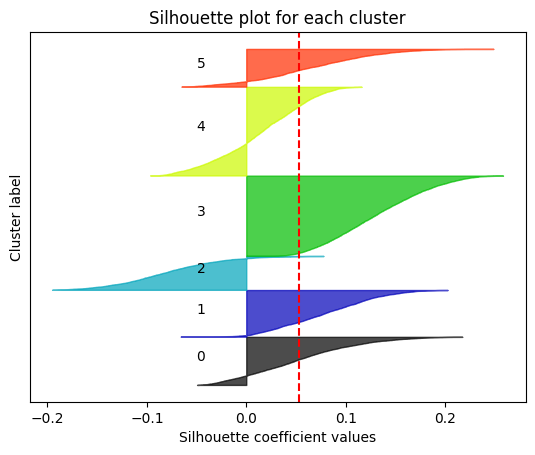

In [51]:
# Calculate silhouette scores
silhouette_avg = silhouette_score(vectors.cpu().detach().numpy(), labels)
sample_silhouette_values = silhouette_samples(vectors.cpu().detach().numpy(), labels)

# Plotting
fig, ax = plt.subplots()
y_lower = 10

for i in range(nn_clusters):
    ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = plt.cm.nipy_spectral(float(i) / nn_clusters)
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

ax.set_title("Silhouette plot for each cluster")
ax.set_xlabel("Silhouette coefficient values")
ax.set_ylabel("Cluster label")

# The vertical line indicates the average silhouette score
ax.axvline(x=silhouette_avg, color="red", linestyle="--")
ax.set_yticks([])
plt.show()


In [52]:
silhouette_avg = silhouette_score(vectors.cpu().detach().numpy(), labels)
print(f"실루엣 평균값: {silhouette_avg}")

실루엣 평균값: 0.05271080881357193


In [53]:
# Calculate silhouette scores
silhouette_avg = silhouette_score(vectors.cpu().detach().numpy(), labels)
sample_silhouette_values = silhouette_samples(vectors.cpu().detach().numpy(), labels)

# Print average silhouette coefficient
print("전체 실루엣 계수 평균값:", silhouette_avg)

# Calculate mean silhouette coefficient for each cluster
cluster_avg_silhouette = []
for i in range(nn_clusters):
    ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
    cluster_avg = np.mean(ith_cluster_silhouette_values)
    cluster_avg_silhouette.append(cluster_avg)
    print(f"클러스터 {i+1}의 평균 실루엣 계수: {cluster_avg}")

전체 실루엣 계수 평균값: 0.05271081
클러스터 1의 평균 실루엣 계수: 0.052539579570293427
클러스터 2의 평균 실루엣 계수: 0.07897104322910309
클러스터 3의 평균 실루엣 계수: -0.0813356563448906
클러스터 4의 평균 실루엣 계수: 0.1313246339559555
클러스터 5의 평균 실루엣 계수: 0.013796862214803696
클러스터 6의 평균 실루엣 계수: 0.06507457792758942


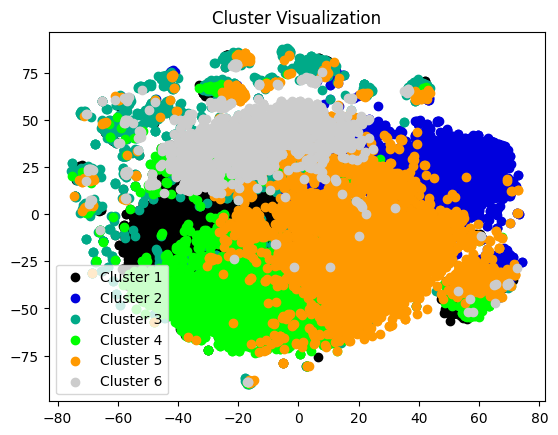

In [54]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# 2차원으로 축소된 데이터 생성
tsne = TSNE(n_components=2, random_state=42)
data_2d = tsne.fit_transform(vectors.cpu().detach().numpy())

# 시각화
fig, ax = plt.subplots()
colors = plt.cm.nipy_spectral(np.linspace(0, 1, nn_clusters))

# 클러스터 중심 시각화
for i, color in zip(range(nn_clusters), colors):
    cluster_points = data_2d[labels == i]
    ax.scatter(cluster_points[:, 0], cluster_points[:, 1], color=color, label=f"Cluster {i+1}")

ax.set_title("Cluster Visualization")
ax.legend()
plt.show()

In [55]:
# Calculate silhouette scores
silhouette_avg = silhouette_score(vectors.cpu().detach().numpy(), labels)
sample_silhouette_values = silhouette_samples(vectors.cpu().detach().numpy(), labels)

# Print silhouette scores
for i in range(len(text_data)):
    print(f"Sample {i+1}: Silhouette score = {sample_silhouette_values[i]}")


Sample 1: Silhouette score = 0.07658614218235016
Sample 2: Silhouette score = 0.018117554485797882
Sample 3: Silhouette score = 0.10303094238042831
Sample 4: Silhouette score = 0.05154913291335106
Sample 5: Silhouette score = -0.007681978400796652
Sample 6: Silhouette score = 0.10426679253578186
Sample 7: Silhouette score = 0.08429042249917984
Sample 8: Silhouette score = 0.21430917084217072
Sample 9: Silhouette score = 0.17476196587085724
Sample 10: Silhouette score = 0.048050444573163986
Sample 11: Silhouette score = 0.03887007012963295
Sample 12: Silhouette score = 0.0157040785998106
Sample 13: Silhouette score = 0.0114823579788208
Sample 14: Silhouette score = -0.013562457635998726
Sample 15: Silhouette score = 0.16284732520580292
Sample 16: Silhouette score = 0.06828623265028
Sample 17: Silhouette score = 0.08121383190155029
Sample 18: Silhouette score = -0.1358138769865036
Sample 19: Silhouette score = 0.04644220322370529
Sample 20: Silhouette score = 0.06440986692905426
Sample 2

In [56]:
# Add cluster labels to df
df_with_clusters = df.copy()
df_with_clusters['Cluster'] = labels

# Create lists to store results
result_cluster_labels = []
result_silhouette_scores = []

# Iterate over samples
for i, silhouette_score in enumerate(sample_silhouette_values):
    cluster_label = df_with_clusters['Cluster'].iloc[i]
    result_cluster_labels.append(cluster_label)
    result_silhouette_scores.append(silhouette_score)

# Print and store silhouette scores with cluster labels
for i in range(len(result_cluster_labels)):
    cluster_label = result_cluster_labels[i]
    silhouette_score = result_silhouette_scores[i]
    print(f"Sample {i+1}: Cluster {cluster_label}, Silhouette score = {silhouette_score:.4f}")

# Store average silhouette score
average_silhouette_score = silhouette_avg


Sample 1: Cluster 5, Silhouette score = 0.0766
Sample 2: Cluster 0, Silhouette score = 0.0181
Sample 3: Cluster 5, Silhouette score = 0.1030
Sample 4: Cluster 1, Silhouette score = 0.0515
Sample 5: Cluster 4, Silhouette score = -0.0077
Sample 6: Cluster 5, Silhouette score = 0.1043
Sample 7: Cluster 4, Silhouette score = 0.0843
Sample 8: Cluster 3, Silhouette score = 0.2143
Sample 9: Cluster 3, Silhouette score = 0.1748
Sample 10: Cluster 5, Silhouette score = 0.0481
Sample 11: Cluster 3, Silhouette score = 0.0389
Sample 12: Cluster 4, Silhouette score = 0.0157
Sample 13: Cluster 0, Silhouette score = 0.0115
Sample 14: Cluster 0, Silhouette score = -0.0136
Sample 15: Cluster 3, Silhouette score = 0.1628
Sample 16: Cluster 0, Silhouette score = 0.0683
Sample 17: Cluster 5, Silhouette score = 0.0812
Sample 18: Cluster 2, Silhouette score = -0.1358
Sample 19: Cluster 0, Silhouette score = 0.0464
Sample 20: Cluster 0, Silhouette score = 0.0644
Sample 21: Cluster 2, Silhouette score = -0.06

In [57]:
result_cluster_labels
result_silhouette_scores

0.05271081

In [58]:
import pandas as pd

# Combine cluster labels and silhouette scores
combined_results22 = list(zip(result_cluster_labels, result_silhouette_scores))

# Create a DataFrame from the combined results
df_results22 = pd.DataFrame(combined_results22, columns=['Cluster_Label', 'Silhouette_Score'])

# Save the DataFrame to a CSV file
csv_file_path = "클러스터 값 포함한.csv"
df_results22.to_csv(csv_file_path, index=False)

In [47]:
# Add cluster labels to df
df_with_clusters = df.copy()
df_with_clusters['Cluster'] = labels

# Print silhouette scores with cluster labels
for i, silhouette_score in enumerate(sample_silhouette_values):
    cluster_label = df_with_clusters['Cluster'].iloc[i]
    print(f"Sample {i+1}: Cluster {cluster_label}, Silhouette score = {silhouette_score:.4f}")

Sample 1: Cluster 5, Silhouette score = 0.0766
Sample 2: Cluster 0, Silhouette score = 0.0181
Sample 3: Cluster 5, Silhouette score = 0.1030
Sample 4: Cluster 1, Silhouette score = 0.0515
Sample 5: Cluster 4, Silhouette score = -0.0077
Sample 6: Cluster 5, Silhouette score = 0.1043
Sample 7: Cluster 4, Silhouette score = 0.0843
Sample 8: Cluster 3, Silhouette score = 0.2143
Sample 9: Cluster 3, Silhouette score = 0.1748
Sample 10: Cluster 5, Silhouette score = 0.0481
Sample 11: Cluster 3, Silhouette score = 0.0389
Sample 12: Cluster 4, Silhouette score = 0.0157
Sample 13: Cluster 0, Silhouette score = 0.0115
Sample 14: Cluster 0, Silhouette score = -0.0136
Sample 15: Cluster 3, Silhouette score = 0.1628
Sample 16: Cluster 0, Silhouette score = 0.0683
Sample 17: Cluster 5, Silhouette score = 0.0812
Sample 18: Cluster 2, Silhouette score = -0.1358
Sample 19: Cluster 0, Silhouette score = 0.0464
Sample 20: Cluster 0, Silhouette score = 0.0644
Sample 21: Cluster 2, Silhouette score = -0.06

In [48]:
df_with_clusters

,Unnamed: 0,0,Cluster
0,0,"내 사랑 홍화씨 “여하튼 이 사태, 무조건 다 책임지라고!” 대한민국 품질 보증의 ...",5
1,1,러브파라다이스 머물고 싶다면 지불해야 할 것이다 원하는 것을 얻으려면 희생이 따를 ...,0
2,2,딱 걸렸어!! ＂저저랑 사귀어 주십시오!＂ 사람들이 웅성거렸다 도대체 왜 싫다는데 ...,5
3,3,홀리스타holy star “그땐 미안했어” “네에?” 영문을 몰라 눈이 동그래진...,1
4,4,넌 내 남자야 인기 많은 남자를 애인으로 둔 내가 행운아인 거야 그 계집애들이 아무...,4
...,...,...,...
17727,17727,낯선 그 남자 이을이 움찔하는 순간 욱환에게 손목이 잡혔다“죄송합니다”“미치겠네”“...,4
17728,17728,"아드레날린 러시 석주를 처음 만났을 땐 너무 두려워 그를 구할 수 없었고,두 번째는...",4
17729,17729,페이크 러브Fake Love 모든 것이 가짜였다“난 단 한 번도 널 싫어했던 적 없...,1
17730,17730,나를 잊은 너에게 “그 결혼은 나랑 하죠 형수로는 만나고 싶지 않으니까”위기에 처한...,4


In [18]:
# 실루엣 점수를 저장할 매트릭스 생성
silhouette_matrix = np.column_stack((text_data, sample_silhouette_values))
columns = ["text_data", "silhouette_score"]

# 실루엣 점수를 담은 새로운 데이터프레임 생성
df_silhouette = pd.DataFrame(data=silhouette_matrix, columns=columns)

# 실루엣 점수를 숫자형으로 변환
df_silhouette["silhouette_score"] = pd.to_numeric(df_silhouette["silhouette_score"])

In [8]:
# 데이터프레임을 CSV 파일로 저 ## 이미 저장함.
# df_silhouette.to_csv("클러스터6_silhouette_scores_0613.csv", index=True)

In [15]:
df_silhouette

,text_data,silhouette_score
0,"내 사랑 홍화씨 “여하튼 이 사태, 무조건 다 책임지라고!” 대한민국 품질 보증의 ...",0.076586
1,러브파라다이스 머물고 싶다면 지불해야 할 것이다 원하는 것을 얻으려면 희생이 따를 ...,0.018118
2,딱 걸렸어!! ＂저저랑 사귀어 주십시오!＂ 사람들이 웅성거렸다 도대체 왜 싫다는데 ...,0.103031
3,홀리스타holy star “그땐 미안했어” “네에?” 영문을 몰라 눈이 동그래진...,0.051549
4,넌 내 남자야 인기 많은 남자를 애인으로 둔 내가 행운아인 거야 그 계집애들이 아무...,-0.007682
...,...,...
17727,낯선 그 남자 이을이 움찔하는 순간 욱환에게 손목이 잡혔다“죄송합니다”“미치겠네”“...,-0.056757
17728,"아드레날린 러시 석주를 처음 만났을 땐 너무 두려워 그를 구할 수 없었고,두 번째는...",-0.060268
17729,페이크 러브Fake Love 모든 것이 가짜였다“난 단 한 번도 널 싫어했던 적 없...,0.084349
17730,나를 잊은 너에게 “그 결혼은 나랑 하죠 형수로는 만나고 싶지 않으니까”위기에 처한...,0.107551


In [16]:
from sklearn.metrics.pairwise import cosine_similarity

# 코사인 유사도 메트릭스 초기화
cosine_sim_matrix = np.zeros((nn_clusters, nn_clusters))

# 각 클러스터 간의 코사인 유사도 계산
for i in range(nn_clusters):
    for j in range(nn_clusters):
        # 같은 클러스터일 경우 코사인 유사도는 1로 설정
        if i == j:
            cosine_sim_matrix[i, j] = 1.0
        else:
            # i번째 클러스터와 j번째 클러스터의 코사인 유사도 계산
            vectors_i = vectors[labels == i]
            vectors_j = vectors[labels == j]
            cosine_sim = cosine_similarity(vectors_i.cpu().detach().numpy(), vectors_j.cpu().detach().numpy())
            cosine_sim_matrix[i, j] = np.mean(cosine_sim)

# 코사인 유사도 메트릭스를 데이터프레임으로 변환
df_cosine_sim = pd.DataFrame(cosine_sim_matrix, index=cluster_names, columns=cluster_names)

df_cosine_sim


,Cluster_no1,Cluster_no2,Cluster_no3,Cluster_no4,Cluster_no5,Cluster_no6
Cluster_no1,1.000000,0.593182,0.547233,0.725383,0.652371,0.640903
Cluster_no2,0.593181,1.000000,0.458953,0.612189,0.668670,0.612120
Cluster_no3,0.547233,0.458953,1.000000,0.582895,0.516063,0.522638
Cluster_no4,0.725383,0.612189,0.582896,1.000000,0.698137,0.679950
Cluster_no5,0.652371,0.668670,0.516064,0.698138,1.000000,0.657953
Cluster_no6,0.640903,0.612120,0.522638,0.679950,0.657953,1.000000


In [17]:
# 이미 저장함
#df_cosine_sim.to_csv("클러스터6_코사인유사도_0613.csv", index=True)

In [17]:
Cluster_no1.to_csv("전처리_Cluster_no1_0613.csv",index=False)
Cluster_no2.to_csv("전처리_Cluster_no2_0613.csv",index=False)
Cluster_no3.to_csv("전처리_Cluster_no3_0613.csv",index=False)
Cluster_no4.to_csv("전처리_Cluster_no4_0613.csv",index=False)
Cluster_no5.to_csv("전처리_Cluster_no5_0613.csv",index=False)
Cluster_no6.to_csv("전처리_Cluster_no6_0613.csv",index=False)

In [18]:
#벡터저장.
import numpy as np
import pandas as pd

# 텐서 데이터를 Numpy 배열로 변환
tensor_array = vectors.cpu().detach().numpy()

# Numpy 배열을 DataFrame으로 변환
df = pd.DataFrame(tensor_array)

# DataFrame을 CSV 파일로 저장
df.to_csv("원본_0613_vectors.csv", index=True)
